In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [5]:
print(torch.__version__)

1.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [4]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [5]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1).unsqueeze(1)

In [6]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [7]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1).unsqueeze(1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [ ]:
print(traindata1)
print(train_data)

In [8]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1, 1000])


torch.Size([108056, 1, 1000])

In [9]:
alldata = torch.cat((train_data,traindata1),0)

In [10]:
labels1 = torch.cat((train_label1[:-1,:],label1[:-1,:]),1)

In [11]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

tensor([[ 100.,  110.,  120.,  ..., 3980., 3990., 4000.],
        [  20.,   20.,   20.,  ..., 2000., 2000., 2000.]], dtype=torch.float64)
torch.Size([2, 216112])
torch.Size([3, 108056])


In [12]:
labels1 = torch.transpose(labels1, 0, 1)
print(labels1.shape)

torch.Size([216112, 2])


In [13]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [14]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [15]:

def _batch_norm(x):
  eps_ = torch.finfo(torch.float32).eps
  y = (x - torch.mean(x)) / (torch.std(x) + eps_)
  return y


# define baseline model
class BaselineModel1(nn.Module):
    def __init__(self):
        super(BaselineModel1, self).__init__()
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)


    def forward(self, x):
        #print(x)
        out = self.fc1(x)
        #print(out)
        #raise error
        out = _batch_norm(out)
        #out = self.bn(512)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        #out = self.bn(256)
        out = _batch_norm(out)
        out = torch.sigmoid(out)
        out = self.fc3(out)
        return out

In [16]:
N = 200
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [17]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [18]:

# build the model
model = BaselineModel1().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 4106224336.25
Epoch 1, loss 3566666974.50
Epoch 2, loss 3091683756.25
Epoch 3, loss 2669625657.50
Epoch 4, loss 2295577635.62
Epoch 5, loss 1965065605.62
Epoch 6, loss 1674714895.38
Epoch 7, loss 1420266620.38
Epoch 8, loss 1195965878.19
Epoch 9, loss 996910003.81
Epoch 10, loss 821381066.12
Epoch 11, loss 668462890.47
Epoch 12, loss 537562741.84
Epoch 13, loss 427855988.41
Epoch 14, loss 335556359.11
Epoch 15, loss 258486209.59
Epoch 16, loss 195260784.34
Epoch 17, loss 146015396.82
Epoch 18, loss 109797734.19
Epoch 19, loss 84371577.93
Epoch 20, loss 67626908.55
Epoch 21, loss 55746962.30
Epoch 22, loss 46349686.06
Epoch 23, loss 38790448.68
Epoch 24, loss 32387207.25
Epoch 25, loss 27062315.37
Epoch 26, loss 22802017.64
Epoch 27, loss 19493842.22
Epoch 28, loss 17176109.65
Epoch 29, loss 14753791.48
Epoch 30, loss 13346381.19
Epoch 31, loss 11793097.30
Epoch 32, loss 11041312.99
Epoch 33, loss 10187903.11
Epoch 34, loss 9467920.47
Epoch 35, loss 9189101.44
Epoch 36, lo

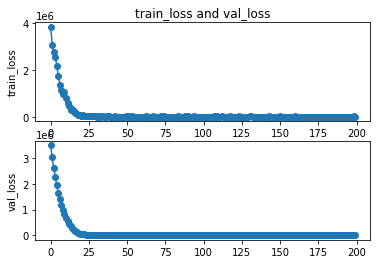

In [25]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and val_loss')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [23]:
print(y1)

[3824088.75, 3051407.0, 2736487.5, 2557844.0, 2169474.5, 1717167.5, 1360262.375, 1138541.25, 958653.0, 1055976.5, 776904.875, 601321.375, 472149.125, 270370.1875, 344458.84375, 241554.0, 136773.796875, 124097.234375, 69460.265625, 56286.23046875, 45701.4765625, 51763.09375, 32777.265625, 34831.8671875, 29355.505859375, 24908.46484375, 25519.32421875, 12621.990234375, 20414.6015625, 11657.65625, 7673.65625, 9789.75, 5285.8291015625, 11654.6591796875, 28608.5, 6403.39794921875, 2941.67919921875, 9189.94921875, 9416.46484375, 2506.366943359375, 6480.83203125, 3684.063232421875, 25305.02734375, 5958.5830078125, 4437.3017578125, 1164.8607177734375, 2945.140625, 6342.80859375, 2097.2451171875, 10351.5, 1376.494140625, 37372.75, 6076.09912109375, 9412.025390625, 759.6907958984375, 4935.54296875, 4298.4189453125, 7292.6357421875, 1700.0244140625, 6036.189453125, 3527.229248046875, 1864.53564453125, 21696.21484375, 1880.238525390625, 3306.5615234375, 3964.438232421875, 3540.751708984375, 11640.

In [24]:
print(y3)

[2868.002826649004, 2650.6578289134263, 2779.373226889314, 2615.1615837574477, 2727.789418407088, 2635.5260849832425, 2690.6580780241434, 2475.371830778302, 2756.824007036196, 2537.0363534361036, 2640.6441069738394, 2435.5249650154, 2399.887212001342, 2946.893221570103, 2727.0330799636918, 2827.2633323328496, 2406.364645600911, 3132.289028679129, 2304.53222244096, 2395.6864235507696, 2656.528665552073, 2888.906927872083, 2610.614880892347, 2303.0844168942403, 2819.2158518301576, 2670.574812130516, 2635.113758378848, 2980.354147432814, 2508.3217499476323, 2519.0487728478774, 2736.66430700429, 2807.646291874845, 2256.9864163744414, 2617.0330467489293, 2324.2146474919705, 2386.1125745271383, 2482.0539536234637, 2825.952757455623, 2658.200118457904, 2937.6355853265422, 2636.7022850544236, 2576.206364045432, 2660.665183558838, 2950.5528505054463, 2871.291757077896, 2611.6000923224924, 2485.1227028476446, 2872.227918122944, 2516.0637764651347, 2673.208715505136, 2887.8052989425582, 2407.0287

In [21]:
model.eval()

BaselineModel1(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [20]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [21]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'test_loss')

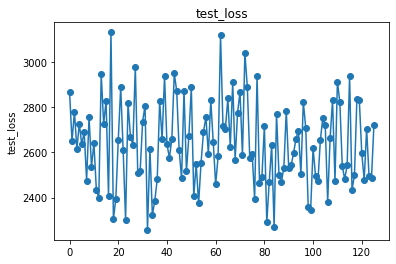

In [22]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [ ]:
for data in testloader:
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    loss = loss/128
    print("loss",loss)
    print("predicted parameter:", predictions)
    print("setting parameter:", labels)

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [17]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel1.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))